<a href="https://colab.research.google.com/github/LennonLab/sporeAI/blob/dylan/CellSAM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CellSAM segmentation

Make sure to change runtime type to GPU for ML applications <br>
- Runtime -> Change runtime type -> T4 GPU



### Getting Started

In [3]:
# have to run the below command for every new colab session
!pip install git+https://github.com/vanvalenlab/cellSAM.git

  Cloning https://github.com/vanvalenlab/cellSAM.git to /tmp/pip-req-build-nvdi1a9u
  Running command git clone --filter=blob:none --quiet https://github.com/vanvalenlab/cellSAM.git /tmp/pip-req-build-nvdi1a9u
  Resolved https://github.com/vanvalenlab/cellSAM.git to commit a392cdd199eebd11646cf6dd115a992af33f6365
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-install-aw414915/segment-anything_5ae60d1779b3478fb5cf33dc41138d89
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-install-aw414915/segment-anything_5ae60d1779b3478fb5cf33dc41138d89
  Resolved https://github.com/facebookresearch/segment-anything.git to commit dca509fe793f601edb92606367a655c15ac00fdf
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 7

In [4]:
from cellSAM import segment_cellular_image, get_model
import numpy as np
import torch
from scipy.ndimage import binary_dilation
import matplotlib.pyplot as plt
from skimage import io
import matplotlib.patches as patches
import cv2


/usr/local/lib/python3.10/dist-packages/torchvision/datapoints/__init__.py:12: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https://github.com/pytorch/vision/issues/6753, and you can also check out https://github.com/pytorch/vision/issues/7319 to learn more about the APIs that we suspect might involve future changes. You can silence this warning by calling torchvision.disable_beta_transforms_warning().
  warnings.warn(_BETA_TRANSFORMS_WARNING)


In [5]:
def sidebyside(img1, img2, title1='', title2=''):
  fig, axes = plt.subplots(1,2, figsize=(16,16))

  # image 1
  axes[0].imshow(img1)
  axes[0].set_title(title1)

  # image 2
  axes[1].imshow(img2)
  axes[1].set_title(title2)

  plt.show()




**cellSAM on test image from cellSAM people**

In [6]:
# download test image from cellSAM files
# !curl -O https://storage.googleapis.com/cellsam-data/yeaz.npy

# img = np.load('yeaz.npy')
# print(img.shape)

# plt.imshow(img)
# plt.show()

# Run segmentation of img
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# mask, embedding, bounding_boxes = segment_cellular_image(img, device=str(device))

# sidebyside(img, mask)

****
**cellSAM on our microscopy images**

In [9]:
imgpath = "20240917_delta6_100x_1.tif"
img = io.imread(imgpath)
img = cv2.resize(img, (0,0), fx=0.5, fy=0.5)
print(img.shape)

(804, 804, 3)


In [10]:
import scipy.ndimage as ndi

sigma = 1
img = ndi.filters.gaussian_filter(img, sigma)


<ipython-input-10-cfb78ac82a5a>:4: DeprecationWarning: Please import `gaussian_filter` from the `scipy.ndimage` namespace; the `scipy.ndimage.filters` namespace is deprecated and will be removed in SciPy 2.0.0.
  img = ndi.filters.gaussian_filter(img, sigma)


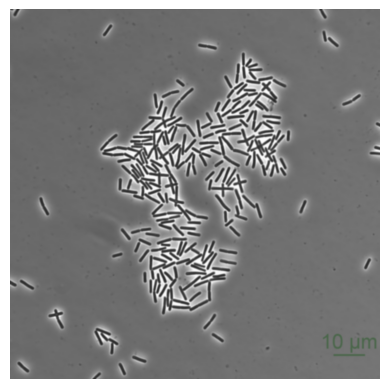

In [11]:
plt.imshow(img)
plt.axis('off')
plt.show()

**Preprocessing**

(1608, 1608, 3)
Min value: 41
Max value: 255


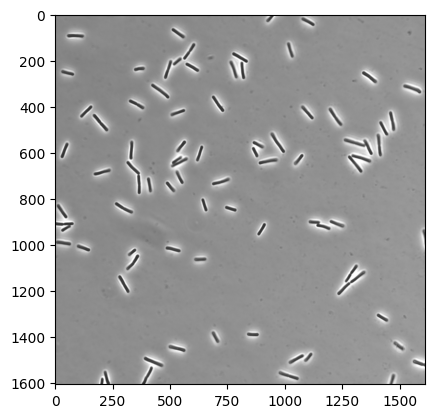

In [57]:
import cv2
from skimage import io

img_path = "20240917_delta6_5.tif"
img = io.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
img = InpaintImage(img)
print(img.shape)
print(f"Min value: {img[:][:].flatten().min()}")
print(f"Max value: {img[:][:].flatten().max()}")
plt.imshow(img)


In [55]:
def InpaintImage(img):
  mask = (img[:,:,0] != img[:,:,1]) | (img[:,:,0] != img[:,:,2])
  mask = mask.astype(np.uint8) * 255

  inpainted = cv2.inpaint(img, mask, inpaintRadius=5, flags=cv2.INPAINT_TELEA)
  return inpainted

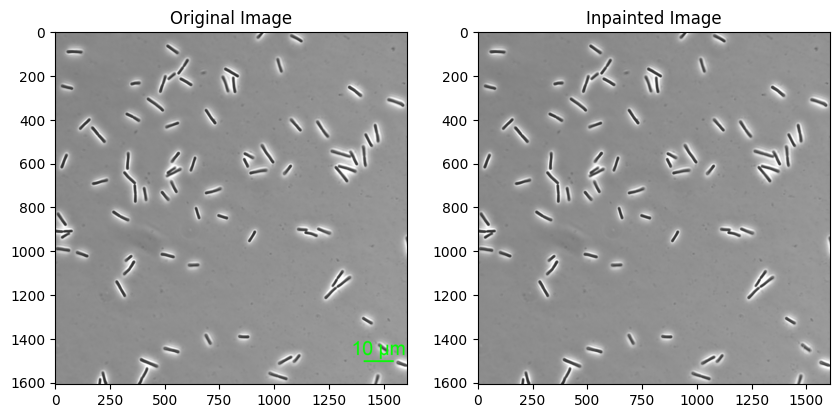

In [54]:
mask = (img[:,:,0] != img[:,:,1]) | (img[:,:,0] != img[:,:,2])
mask = mask.astype(np.uint8) * 255

inpainted = cv2.inpaint(img, mask, inpaintRadius=5, flags=cv2.INPAINT_TELEA)

# Display the result
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title("Original Image")
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.subplot(1, 2, 2)
plt.title("Inpainted Image")
plt.imshow(cv2.cvtColor(inpainted, cv2.COLOR_BGR2RGB))
plt.show()


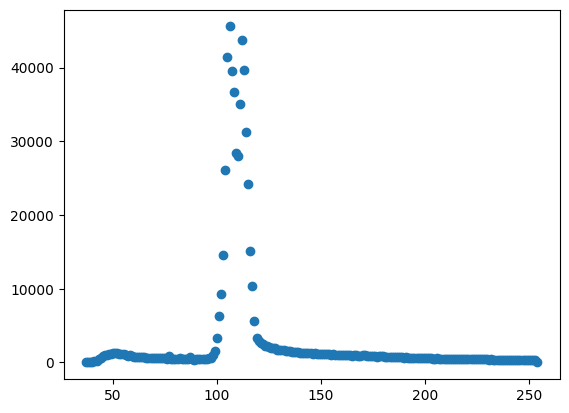

In [7]:
# histogram used to view the distribution of pixel intensities
from skimage.exposure import histogram

(counts, bins) = histogram(img[:,:,0])

fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.scatter(bins, counts)

In [8]:
def HistandCDF(img1, img2, cdf=True):
  # compute histograms
  counts_1, bins_1 = histogram(img1)
  counts_2, bins_2 = histogram(img2)

  # compute cumulative distribution functions
  img_cdf_1, bins_1 = exposure.cumulative_distribution(img1, 256)
  img_cdf_1 = img_cdf_1
  img_cdf_2, bins_2 = exposure.cumulative_distribution(img2)
  img_cdf_2 = img_cdf_2

  # view images and histograms
  if cdf:
    fig, axes = plt.subplots(2,2, figsize=(10,10))
  else:
    fig, axes = plt.subplots(1,2, figsize=(10,10))

  if cdf:
    ## original image
    axes[0,0].imshow(img1, cmap='gray')
    axes[0,0].set_title('Original Image')
    axes[0, 0].axis('off')

    ## 2 image
    axes[0,1].imshow(img2, cmap='gray')
    axes[0,1].set_title('Processed Image')
    axes[0, 1].axis('off')


    ## original histogram and cdf
    right_y_axis_0 = axes[1,0].twinx()
    axes[1,0].scatter(bins_1, counts_1, label='Original', color='blue')
    # right_y_axis_0.set_ylim(0,1)
    right_y_axis_0.plot(bins_1, img_cdf_1, color='red')
    axes[1, 0].axis('off')

    ## 2 histogram and cdf
    right_y_axis_1 = axes[1,1].twinx()
    axes[1,1].scatter(bins_2, counts_2, label='Processed', color='blue')
    # right_y_axis_1.set_ylim(0,1)
    right_y_axis_1.plot(bins_2, img_cdf_2, color='red')
    axes[1, 1].axis('off')

  else:
      ## original image
      axes[0].imshow(img1, cmap='gray')
      axes[0].set_title('Original Image')
      axes[0].axis('off')

      ## 2 image
      axes[1].imshow(img2, cmap='gray')
      axes[1].set_title('Processed Image')
      axes[1].axis('off')

  plt.show()

/usr/local/lib/python3.10/dist-packages/skimage/_shared/utils.py:438: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel, or set channel_axis.
  return func(*args, **kwargs)


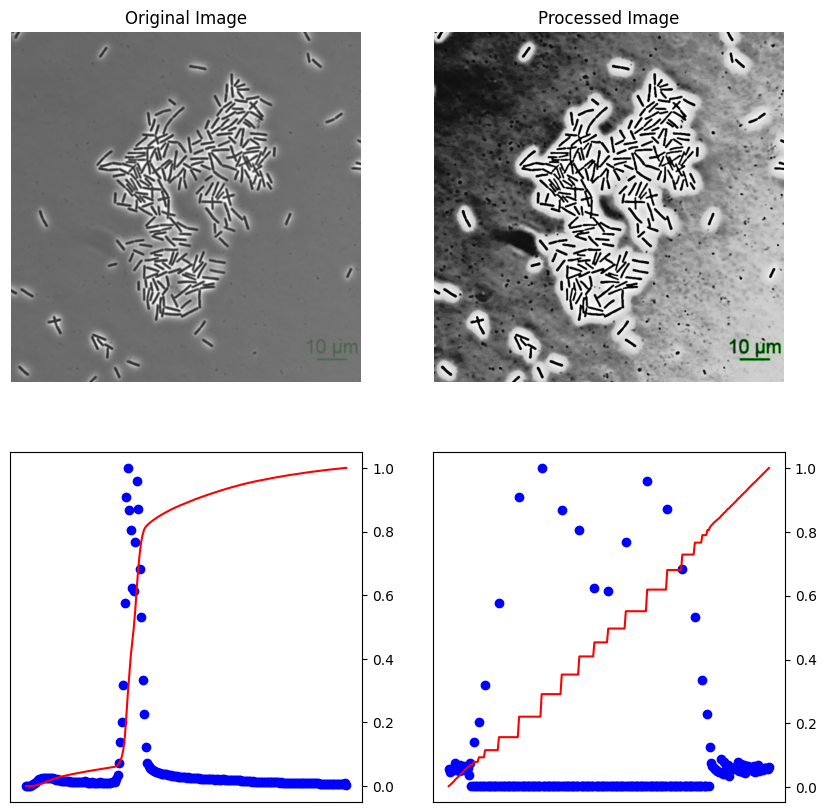

In [9]:
from skimage.exposure import equalize_hist, equalize_adapthist, rescale_intensity, adjust_gamma
from skimage import exposure

img_copy = img
img_eq = equalize_hist(img_copy)

# HistandCDF(img_copy, img_eq,)




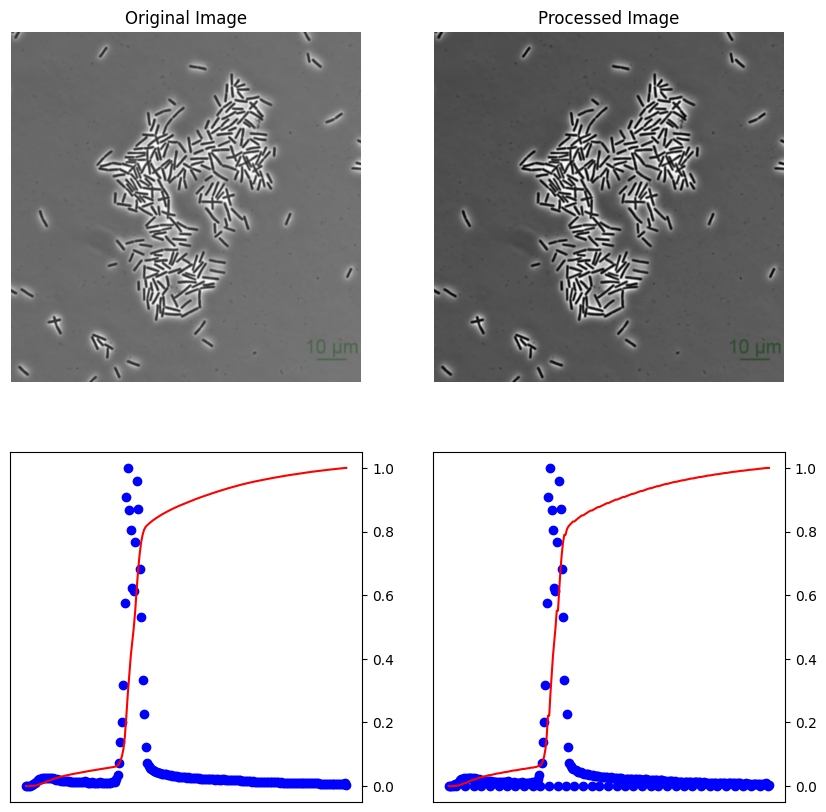

In [10]:
img_copy = img
img_rescale = rescale_intensity(img_copy)

HistandCDF(img_copy, img_rescale)

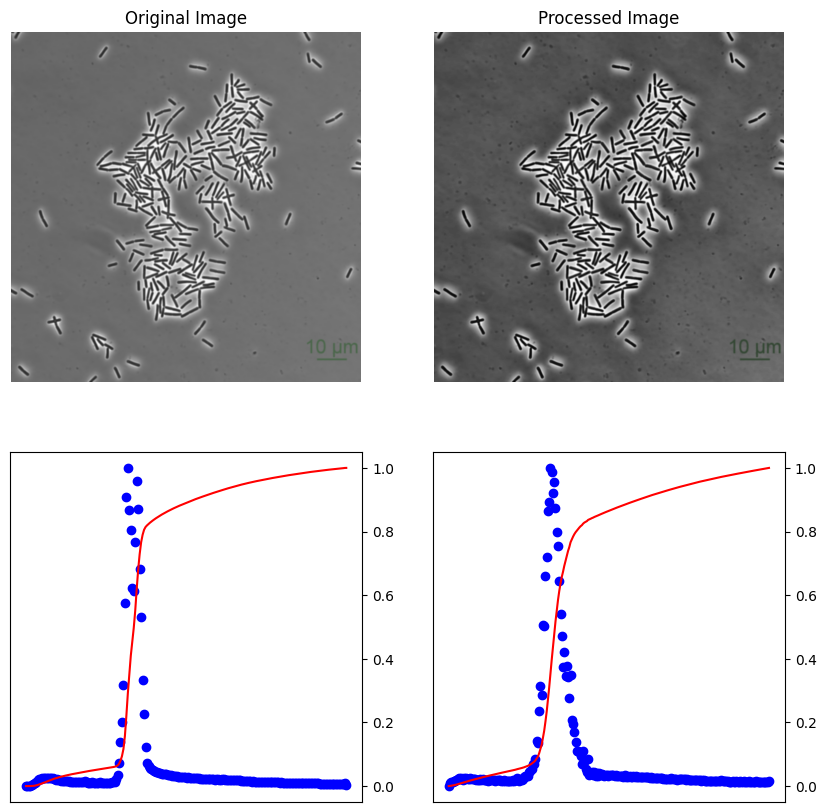

In [11]:
img_copy = img
img_eqadapt = equalize_adapthist(img_copy)

HistandCDF(img_copy, img_eqadapt)

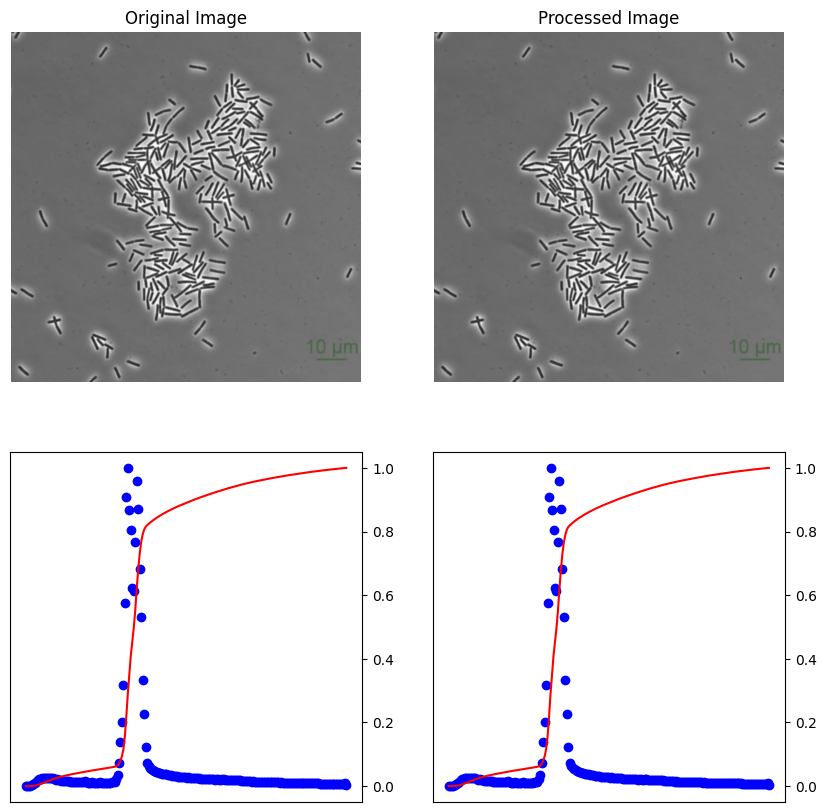

In [12]:
img_copy = img
img_gamma = adjust_gamma(img_copy, gamma=1, gain=1)

HistandCDF(img_copy, img_gamma)

In [13]:
img_all = adjust_gamma(img_copy, gamma=1, gain=1)
img_all = equalize_adapthist(img_all)

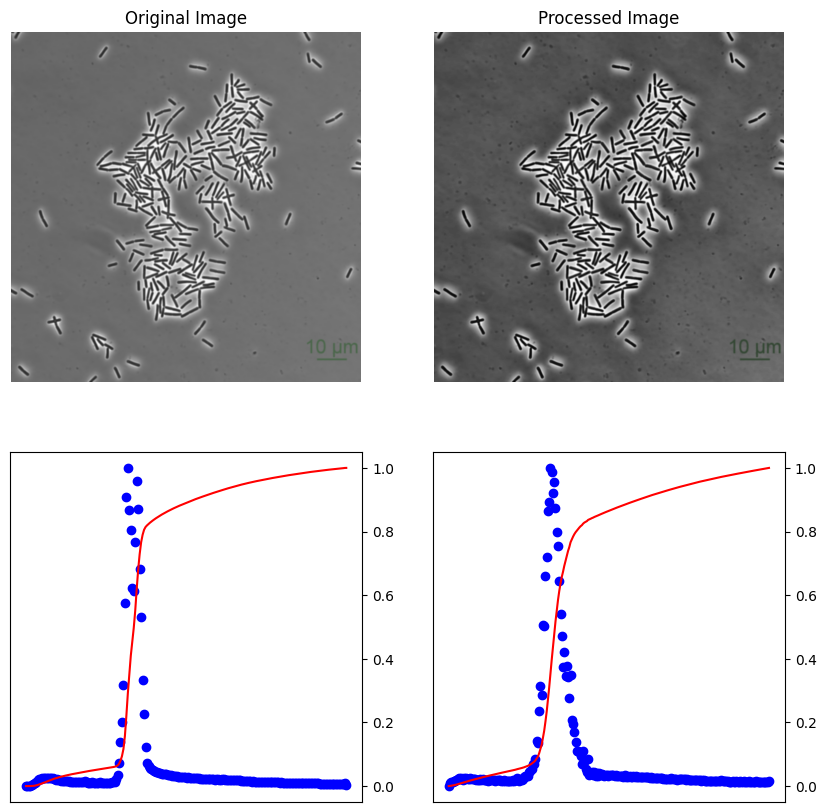

In [14]:
HistandCDF(img, img_all)

100%|██████████| 784M/784M [00:20<00:00, 38.4MiB/s]
/usr/local/lib/python3.10/dist-packages/cellSAM/sam_inference.py:272: UserWarning: Low IOU threshold, ignoring mask.
  warnings.warn("Low IOU threshold, ignoring mask.")


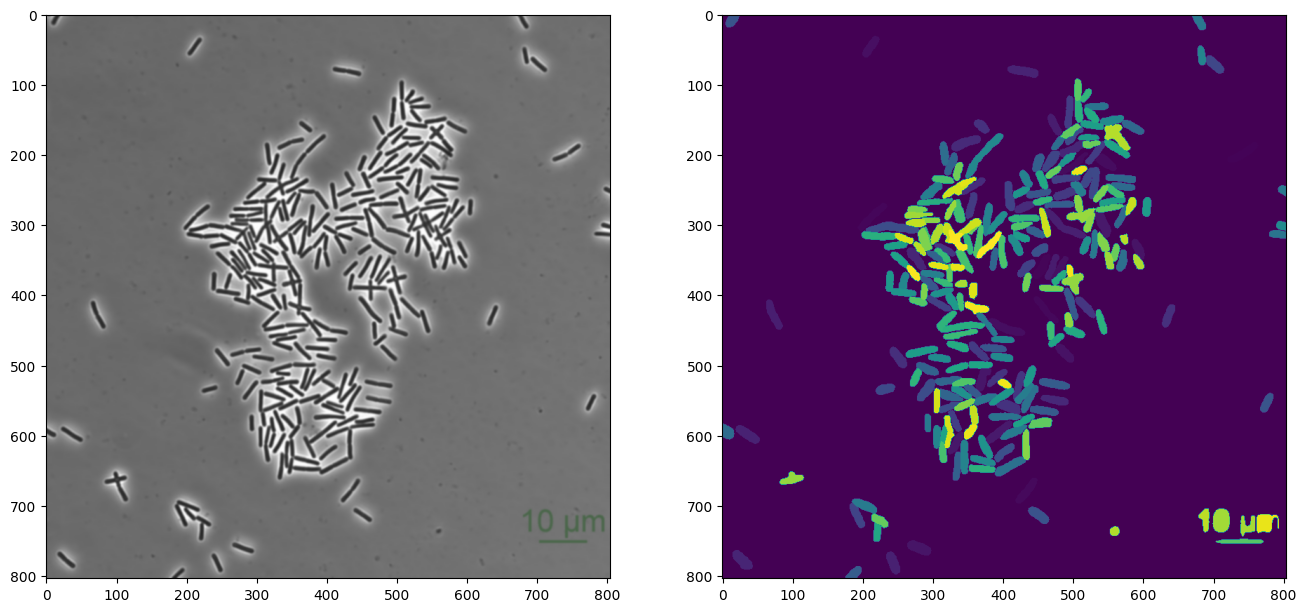

In [15]:
# Run segmentation of img
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
mask, embedding, bounding_boxes = segment_cellular_image(img_gamma, device=str(device))
sidebyside(img, mask)

**Cell Counts**

In [21]:
values, counts = np.unique(mask, return_counts=True)
cells = dict(zip(values, counts))
print(len(values))

249


In [22]:
counts[0:10]

array([561898,    393,    576,    498,    554,    467,    487,    412,
          428,    599])

In [23]:
np.average(counts[1:])

340.7983870967742

In [24]:
np.min(counts)

53

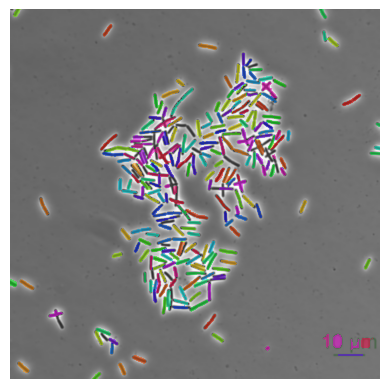

In [25]:
colored_mask = np.ma.masked_where(mask==0, mask)
plt.imshow(img)

#overlay the mask with a color map and transparency
plt.imshow(colored_mask, cmap='hsv', alpha=0.5)
plt.axis('off')
plt.show()

**using CV**

In [26]:
img_blurred = cv2.GaussianBlur(img, (5,5), 0)


In [27]:
#!pip install ipywidgets

In [28]:
from ipywidgets import interact

%matplotlib inline

@interact(thres=(0,255,1))
def threshold_image(thres):
  img_thres = img_blurred > thres
  img_thres = np.where(img_thres, 255, 0).astype(np.uint8)

  plt.figure(figsize=(5,5))
  plt.imshow(img_thres, interpolation='none')
  plt.show()

interactive(children=(IntSlider(value=127, description='thres', max=255), Output()), _dom_classes=('widget-int…

In [29]:
thres = 93

_, img_thres = cv2.threshold(img_blurred, thres, 255, cv2.THRESH_BINARY)

In [30]:
img_thres.shape

(804, 804, 3)

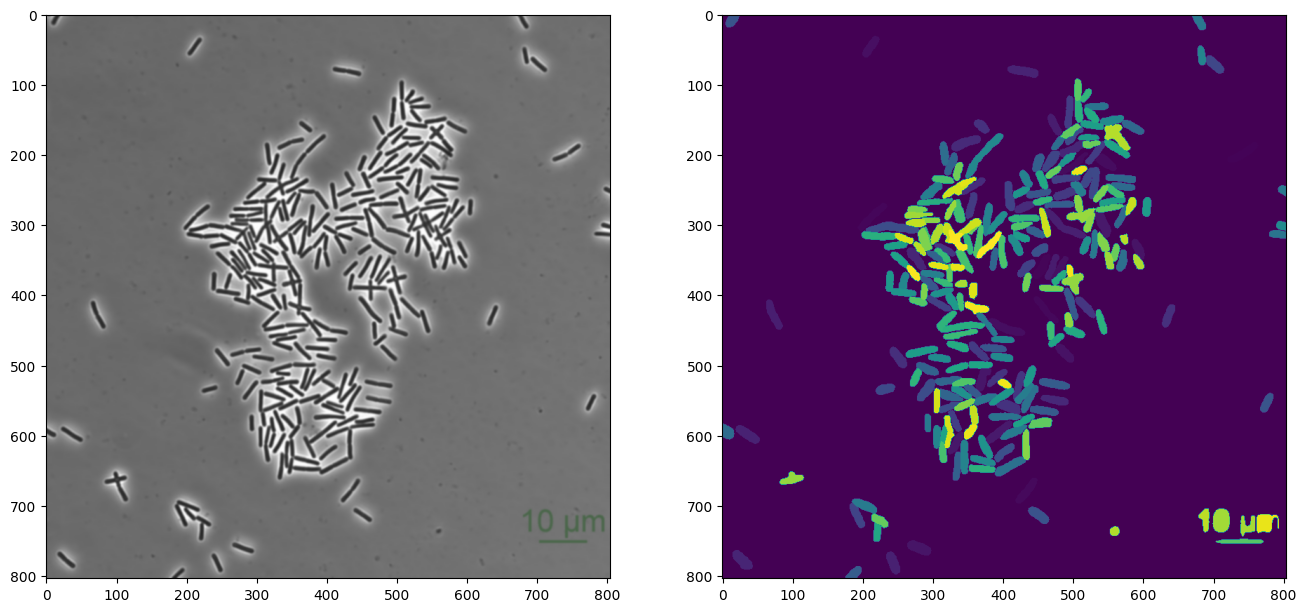

In [31]:
# Run segmentation of img
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
mask, embedding, bounding_boxes = segment_cellular_image(img, device=str(device))
sidebyside(img, mask)

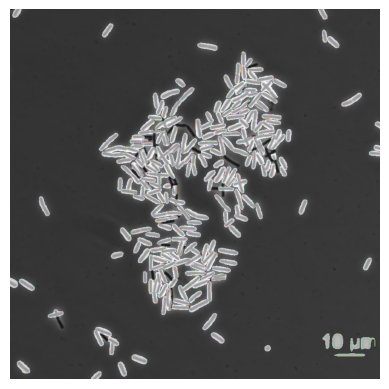

In [32]:
# colored_mask = np.ma.masked_where(mask==0, mask)
binary_mask = mask > 0
plt.imshow(img)

#overlay the mask with a color map and transparency
plt.imshow(binary_mask, cmap='cubehelix', alpha=.5)
plt.axis('off')
plt.show()

In [33]:
def RunImage(img, filename):
  # Run segmentation of img
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
  mask, embedding, bounding_boxes = segment_cellular_image(img, device=str(device))

  # Get information
  values, counts = np.unique(mask, return_counts=True)
  # cellSAM sets bckground mask value to 0
  colored_mask = np.ma.masked_where(mask==0, mask)
  binary_mask = mask > 0

  fig, axes = plt.subplots(1,2, figsize=(10,10))

  axes[0].imshow(img)
  axes[0].imshow(colored_mask, cmap='hsv', alpha=0.6)
  axes[0].axis('off')

  axes[1].imshow(img)
  axes[1].imshow(binary_mask, cmap='cubehelix', alpha=.5)
  axes[1].axis('off')

  newfile = "segmented" + filename
  plt.savefig(newfile)
  plt.show()

  return mask, embedding, bounding_boxes, colored_mask, binary_mask


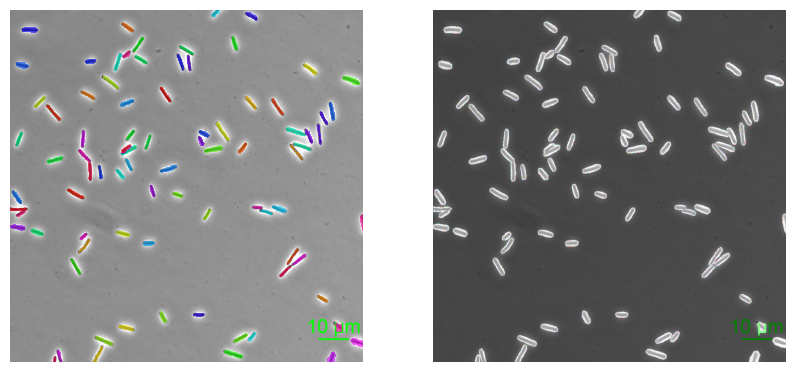

In [34]:
imgpath = "20240917_delta6_5.tif"
img = io.imread(imgpath)
img = cv2.resize(img, (0,0), fx=0.5, fy=0.5)
mask, embedding, bounding_boxes, colored_mask, binary_mask = RunImage(img, imgpath)

In [39]:
print(type(bounding_boxes))
print(bounding_boxes.shape)

<class 'torch.Tensor'>
torch.Size([84, 4])


In [41]:
bbox = bounding_boxes.cpu()
bbox = bbox.detach().numpy()
print(type(bbox))
print(bbox.shape)

<class 'numpy.ndarray'>
(84, 4)


In [1]:
bbox

NameError: name 'bbox' is not defined